# Detecção de Fraudes: *Baseline* e *Benchmark*

In [1]:
import os
import joblib
import requests
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_ks_statistic
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
load_dotenv()
random_state = int(os.environ['SKLEARN_RANDOM_STATE'])

print(os.environ['NOTEBOOKS_RAW_DATA_PATH'])
print(os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'])
print(os.environ['SKLEARN_RANDOM_STATE'])
print(os.environ['NOTEBOOKS_MODELS_PATH'])

../data/raw/
../data/processed/
42
../models/


## Lendo os dados

In [3]:
# conjunto de treino
df_train_maj = pd.read_parquet(
    os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'] + \
        'creditcard_train_major.parquet'
)

# conjunto de treino do treino
df_train_min = pd.read_parquet(
    os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'] + \
        'creditcard_train_minor.parquet'
)

# conjunto de validação
df_val = pd.read_parquet(
    os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'] + \
        'creditcard_val.parquet'
)

df_train_maj.shape, df_train_min.shape, df_val.shape

((227845, 31), (182276, 31), (45569, 31))

### Separação em $X$ e $y$

In [4]:
# conjunto de treino
X_train = df_train_maj.drop('Fraude', axis=1).values
Y_train = df_train_maj['Fraude'].values

X_train.shape, Y_train.shape

((227845, 30), (227845,))

In [5]:
# conjunto de treino do treino
x_train = df_train_min.drop('Fraude', axis=1).values
y_train = df_train_min['Fraude'].values

x_train.shape, y_train.shape

((182276, 30), (182276,))

In [6]:
# conjunto de validação
x_val = df_val.drop('Fraude', axis=1).values
y_val = df_val['Fraude'].values

x_val.shape, y_val.shape

((45569, 30), (45569,))

## Modelo *Baseline* (`DummyClassifier`)

### Validando o modelo

In [7]:
%%time

dummy = DummyClassifier(
    strategy='stratified',
    random_state=random_state
)

dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_val)

print(classification_report(y_val, y_pred))
print('recall 0 =', recall_score(y_val, y_pred, pos_label=0))
print('recall 1 =', recall_score(y_val, y_pred, pos_label=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45470
           1       0.00      0.00      0.00        99

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569

recall 0 = 0.9983285682867825
recall 1 = 0.0
Wall time: 129 ms


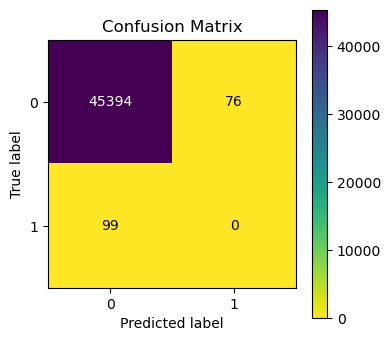

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4,4));
plot_confusion_matrix(y_val, y_pred, cmap='viridis_r', ax=ax);

### Treinando e serializando o modelo

In [9]:
%%time

dummy = DummyClassifier(
    strategy='stratified',
    random_state=random_state
)

dummy.fit(X_train, Y_train)

# salvando o modelo
joblib.dump(
    dummy,
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        f'{DummyClassifier.__name__}' + \
         '_fraud_detection.sav'
)

Wall time: 23 ms


['../models/DummyClassifier_fraud_detection.sav']

## Modelo *Benchmark* (`QuadraticDiscriminantAnalysis`)

### Validando o modelo

In [10]:
%%time

model = QuadraticDiscriminantAnalysis()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
y_proba = model.predict_proba(x_val)

print(classification_report(y_val, y_pred))
print('recall 0 =', recall_score(y_val, y_pred, pos_label=0))
print('recall 1 =', recall_score(y_val, y_pred, pos_label=1))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     45470
           1       0.07      0.85      0.12        99

    accuracy                           0.97     45569
   macro avg       0.53      0.91      0.56     45569
weighted avg       1.00      0.97      0.99     45569

recall 0 = 0.974444688805806
recall 1 = 0.8484848484848485
Wall time: 1.45 s


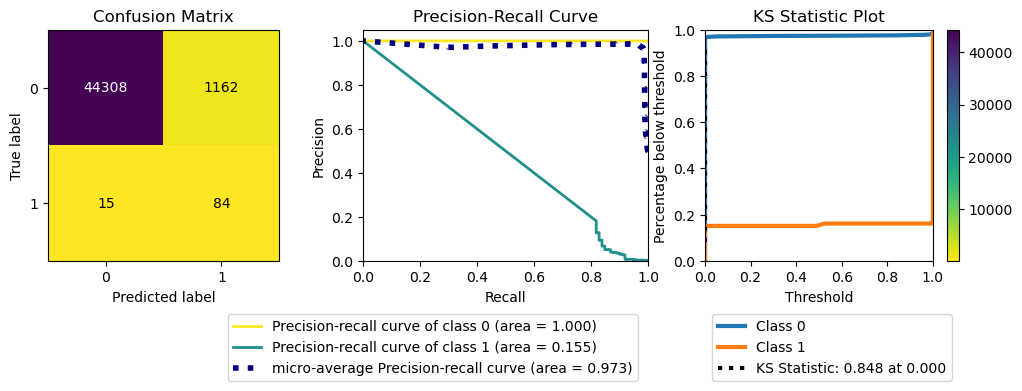

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12.5,3));

plot_confusion_matrix(y_val, y_pred, cmap='viridis_r', ax=ax[0]);
plot_precision_recall(y_val, y_proba, cmap='viridis_r', ax=ax[1]);
plot_ks_statistic(y_val, y_proba, ax=ax[2]);

ax[1].legend(loc='lower left', bbox_to_anchor=(-.5, -.55));
ax[2].legend(loc='lower left', bbox_to_anchor=(0, -.55));

### Treinando e serializando o modelo

In [12]:
%%time

model = QuadraticDiscriminantAnalysis()
model.fit(x_train, y_train)

# salvando o modelo
joblib.dump(
    model,
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        f'{QuadraticDiscriminantAnalysis.__name__}' + \
         '_fraud_detection.sav'
)

Wall time: 1.03 s


['../models/QuadraticDiscriminantAnalysis_fraud_detection.sav']